In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

In [2]:
def show_two_images(images_arr, size=(16, 8), mode='rgb', title_arr=(None,None)):    
    fig=plt.figure(figsize=size, dpi=150)
    
    for i in range(2):
        fig.add_subplot(1, 2, i+1)
        if mode=='grayscale':
            plt.imshow(images_arr[i], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(images_arr[i])
        plt.title(title_arr[i])
        plt.axis('off')

    plt.show()

In [3]:
orig_img_pil = Image.open(input("Enter original image path: "))
ref_img_pil = Image.open(input("Enter reference image path: "))

Enter original image path: orig.png
Enter reference image path: ref.png


In [4]:
orig_image = np.asarray(orig_img_pil)
ref_image = np.asarray(ref_img_pil)

In [5]:
def normilize_image(np_img, mul_const=1.0):
    return mul_const * (np_img-np_img.min()) / (np_img.max() - np_img.min())

# Опорный цвет

In [6]:
orig_vg = widgets.ColorPicker(
    concise=False,
    description='Original color',
    value='blue',
    disabled=False
)

ref_vg = widgets.ColorPicker(
    concise=False,
    description='Reference color',
    value='blue',
    disabled=False
)

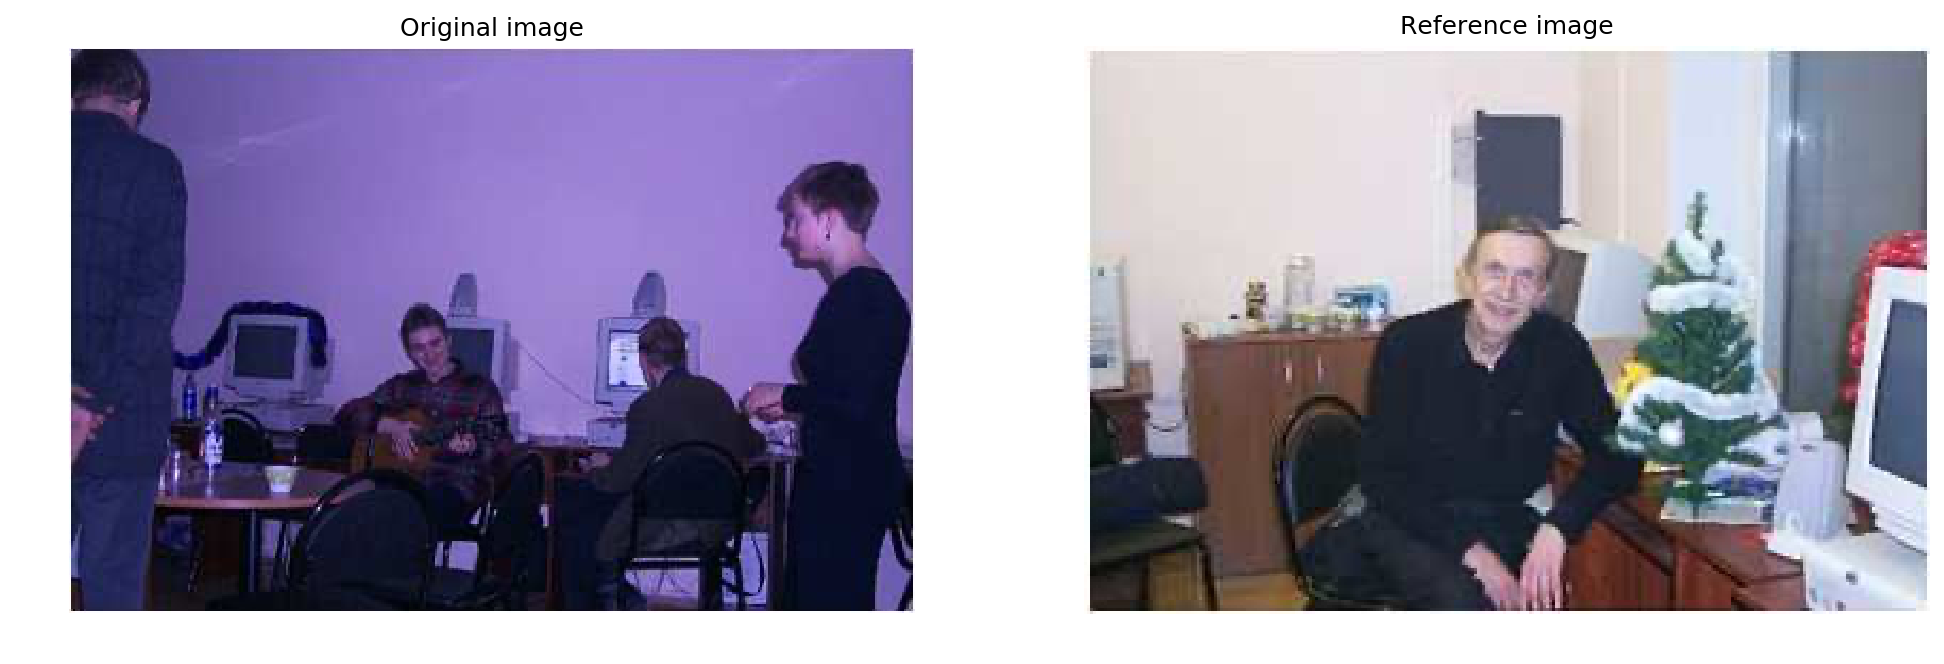

ColorPicker(value='blue', description='Original color')

ColorPicker(value='blue', description='Reference color')

In [7]:
show_two_images((orig_image, ref_image),title_arr=('Original image', 'Reference image') )

display(orig_vg)
display(ref_vg)

In [10]:
def hex_to_rgb(hex_color):
    RGB_color = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return RGB_color

def reference_color(np_img, orig_color, ref_color):
    R_const = ref_color[0] / orig_color[0]
    G_const = ref_color[1] / orig_color[1]
    B_const = ref_color[2] / orig_color[2]

    RGB_const = np.array([R_const, G_const, B_const])    
    scale_img = np.multiply(orig_image, RGB_const)
    
    return normilize_image(scale_img)

In [11]:
orig_hex = orig_vg.value.lstrip('#')
ref_hex = ref_vg.value.lstrip('#')

RGB_orig_color = hex_to_rgb(orig_hex)
RGB_ref_color = hex_to_rgb(ref_hex)

print('Original RGB =', RGB_orig_color)
print('Reference RGB =', RGB_ref_color)

Original RGB = (133, 108, 193)
Reference RGB = (230, 221, 219)


In [12]:
reference_color_img = reference_color(orig_image, RGB_orig_color, RGB_ref_color)

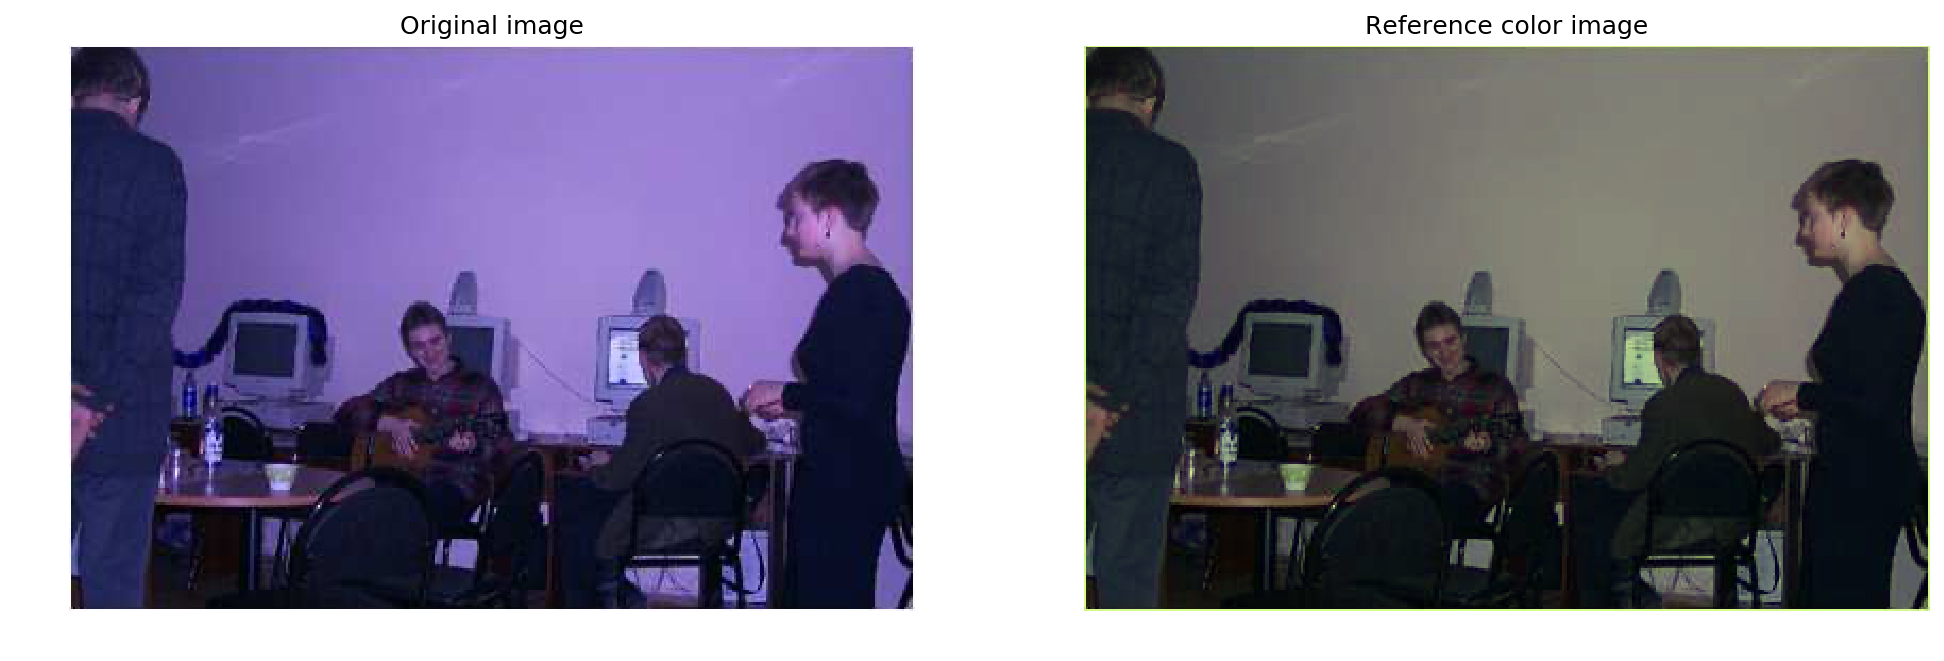

In [13]:
show_two_images((orig_image, reference_color_img),title_arr=('Original image', 'Reference color image'))

# Серый мир

In [14]:
def gray_world(np_img):
    r_mean = np.mean(np_img[:,:,0])
    g_mean = np.mean(np_img[:,:,1])
    b_mean = np.mean(np_img[:,:,2])

    avg = (r_mean + g_mean + b_mean) / 3
    
    temp_img = np.copy(np_img)

    for i, c_mean in enumerate([r_mean, g_mean, b_mean]):
        temp_img[:,:,i] = temp_img[:,:,i] * avg / c_mean
    
    return temp_img

In [15]:
gray_world_img = gray_world(orig_image)

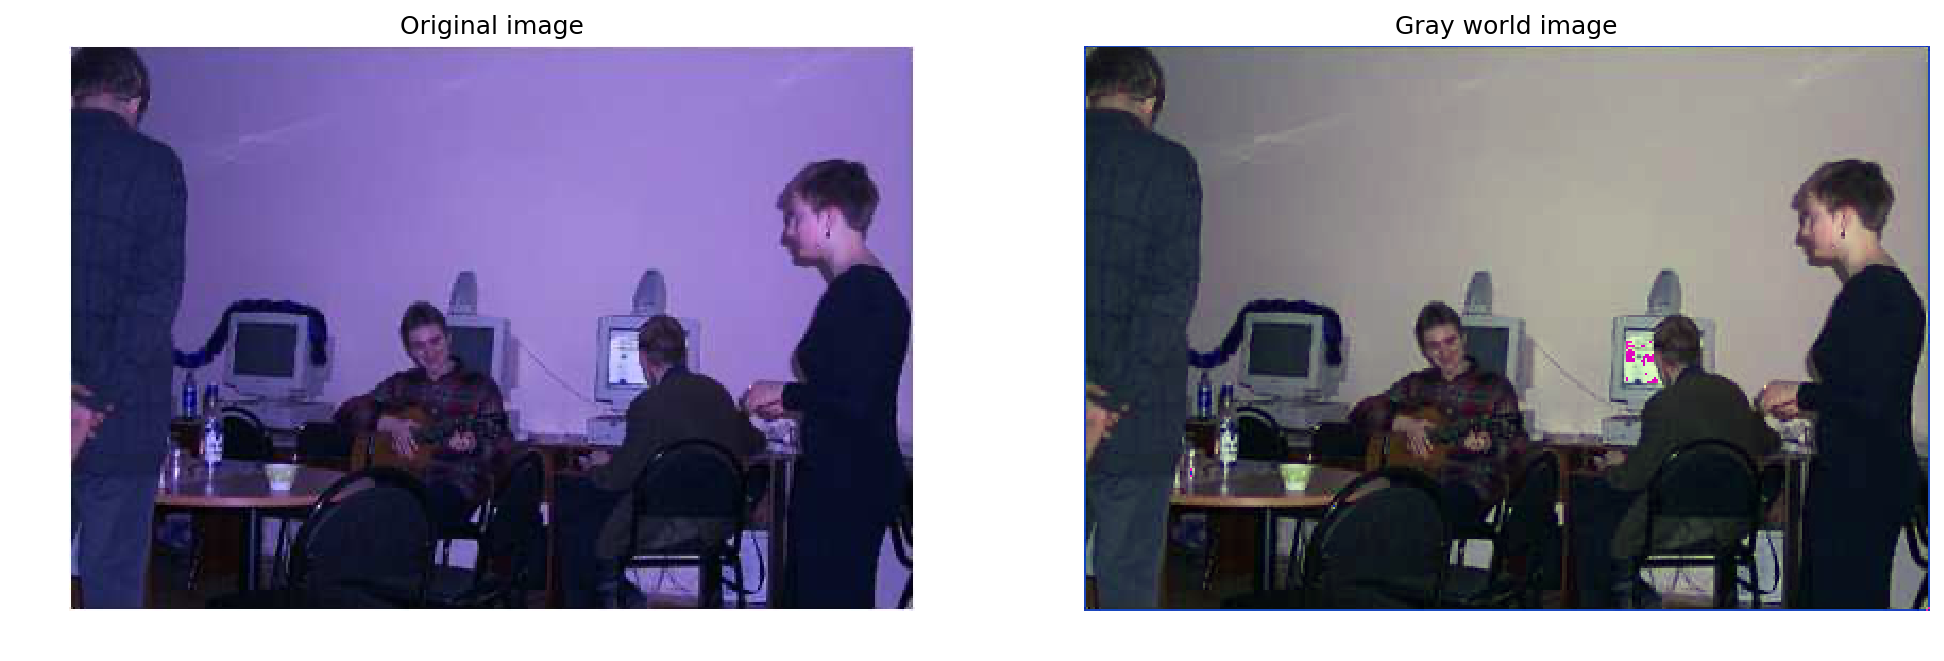

In [16]:
show_two_images((orig_image, gray_world_img),title_arr=('Original image', 'Gray world image'))

# Пока не понял, шо делать

# Коррекция на основе гистограммы

In [17]:
path = 'third_part.png'
img_pil = Image.open(path)
np_image = np.asarray(img_pil)
np_image_rgb = np.asarray(img_pil.convert('RGB'))

In [32]:
def plot_hist(np_img, color='black', title=None, show=True, yscale_type='linear'):
    histogram, bin_edges = np.histogram(
            np_img, bins=256, range=(0, 256)
    )
    plt.bar(bin_edges[0:-1], histogram, width=1.0, color=color)       
    
    plt.xlabel('brightness')
    plt.ylabel('number of pixels')

    plt.grid(True)
    plt.yscale(yscale_type)
    
    if title:
        plt.title(title)
    if show:
        plt.show()
        
def plot_hist_rgb(np_img, yscale_type='linear', title=None):
    columns = 3
    rows = 1
    
    fig=plt.figure(figsize=(20, 5), dpi=150)
    
    for i, c in enumerate(['r','g','b']):
        fig.add_subplot(1, 3, i+1)
        subtitle=c + ' channel'
        plot_hist(np_img, title=subtitle, show=False, color=c)
        
    plt.show()
    
def plot_two_hist_compare(np_img_arr, yscale_type='linear', title_arr=(None,None), figsize=(14, 8)):
    fig=plt.figure(figsize=figsize)
    
    for i in range(2):
        fig.add_subplot(1, 2, i+1)
        plot_hist(np_img_arr[i], title=title_arr[i], show=False)

    plt.show()



## 1. Нормализация

In [33]:
def normilize_image_rgb(np_img, mul_const=255.0):
    temp = np.zeros(np_img.shape, dtype='float')
    for i in range(3):
        temp[:,:,i] = normilize_image(np_img[:,:,i], mul_const)
    return temp.astype('int')

In [34]:
norm_img = normilize_image(np_image, 255.0)
norm_img_rgb = normilize_image_rgb(np_image_rgb, 255.0)

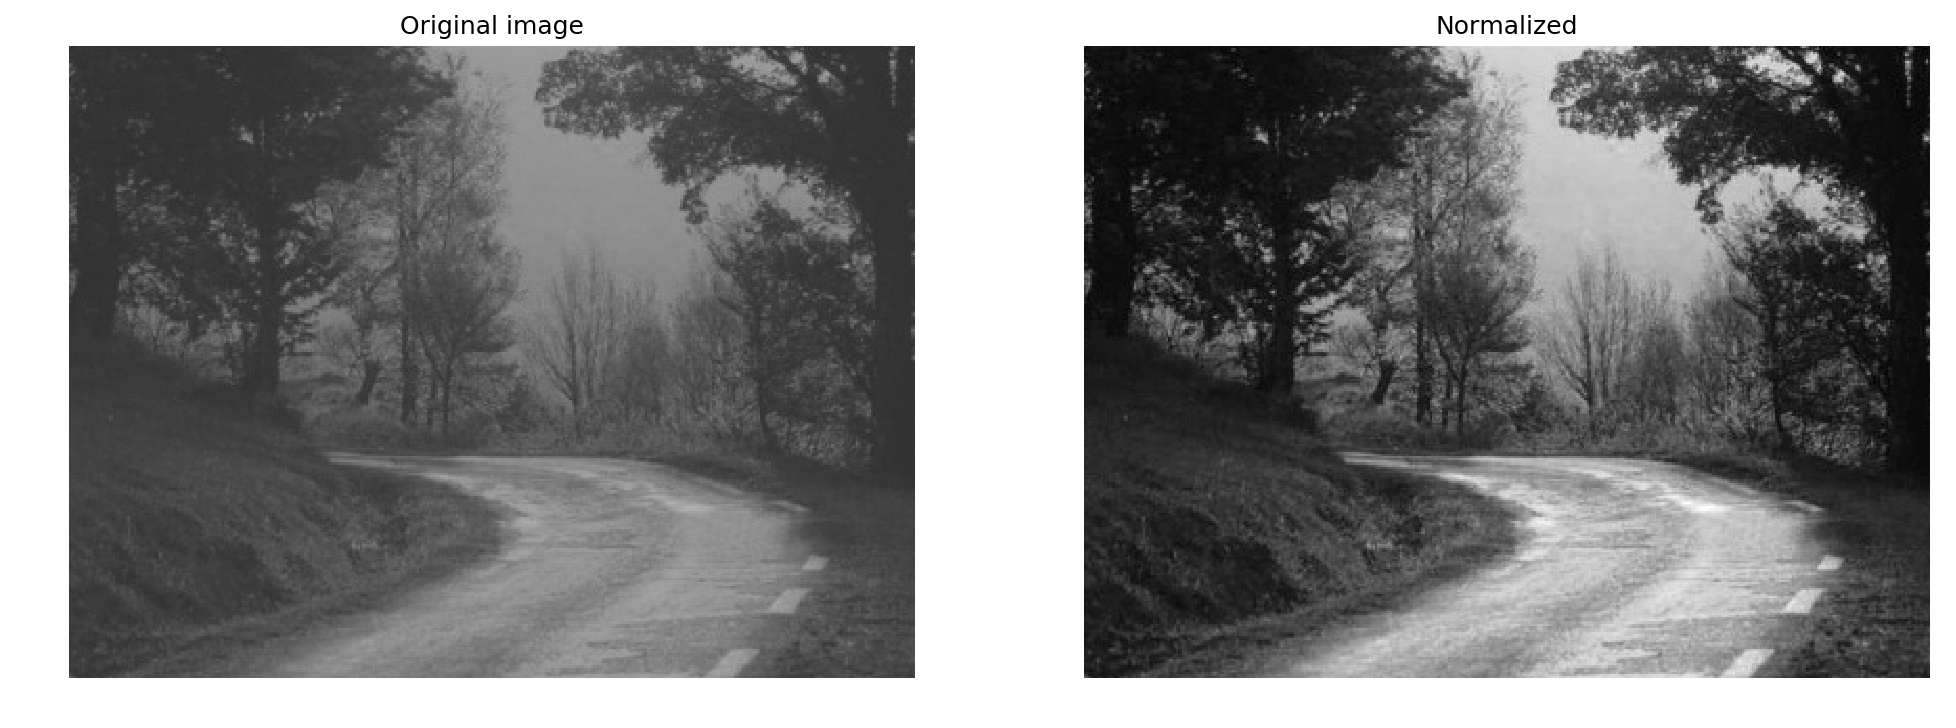

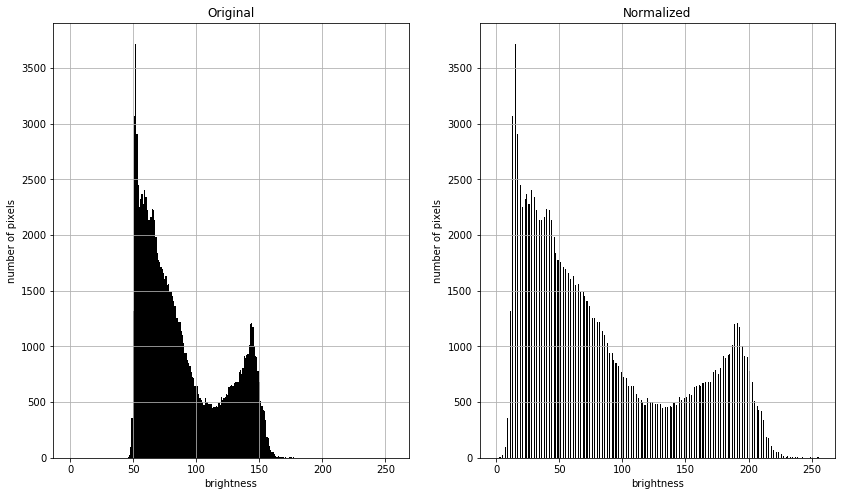

In [35]:
show_two_images((np_image, norm_img),title_arr=('Original image', 'Normalized'), mode='grayscale')
plot_two_hist_compare((np_image, norm_img), title_arr=('Original', 'Normalized'))

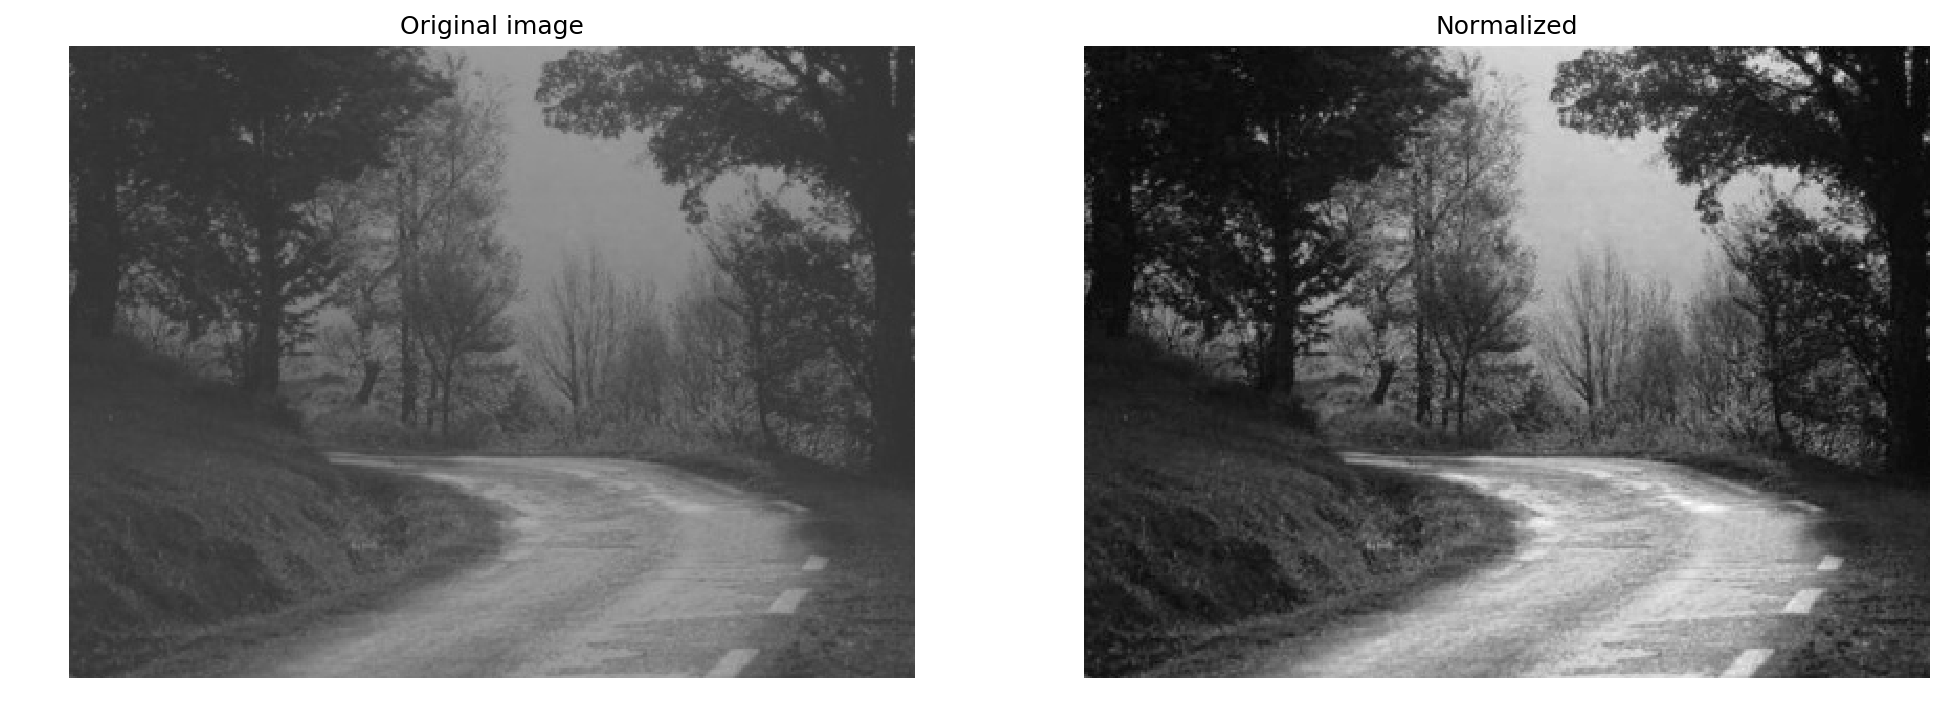

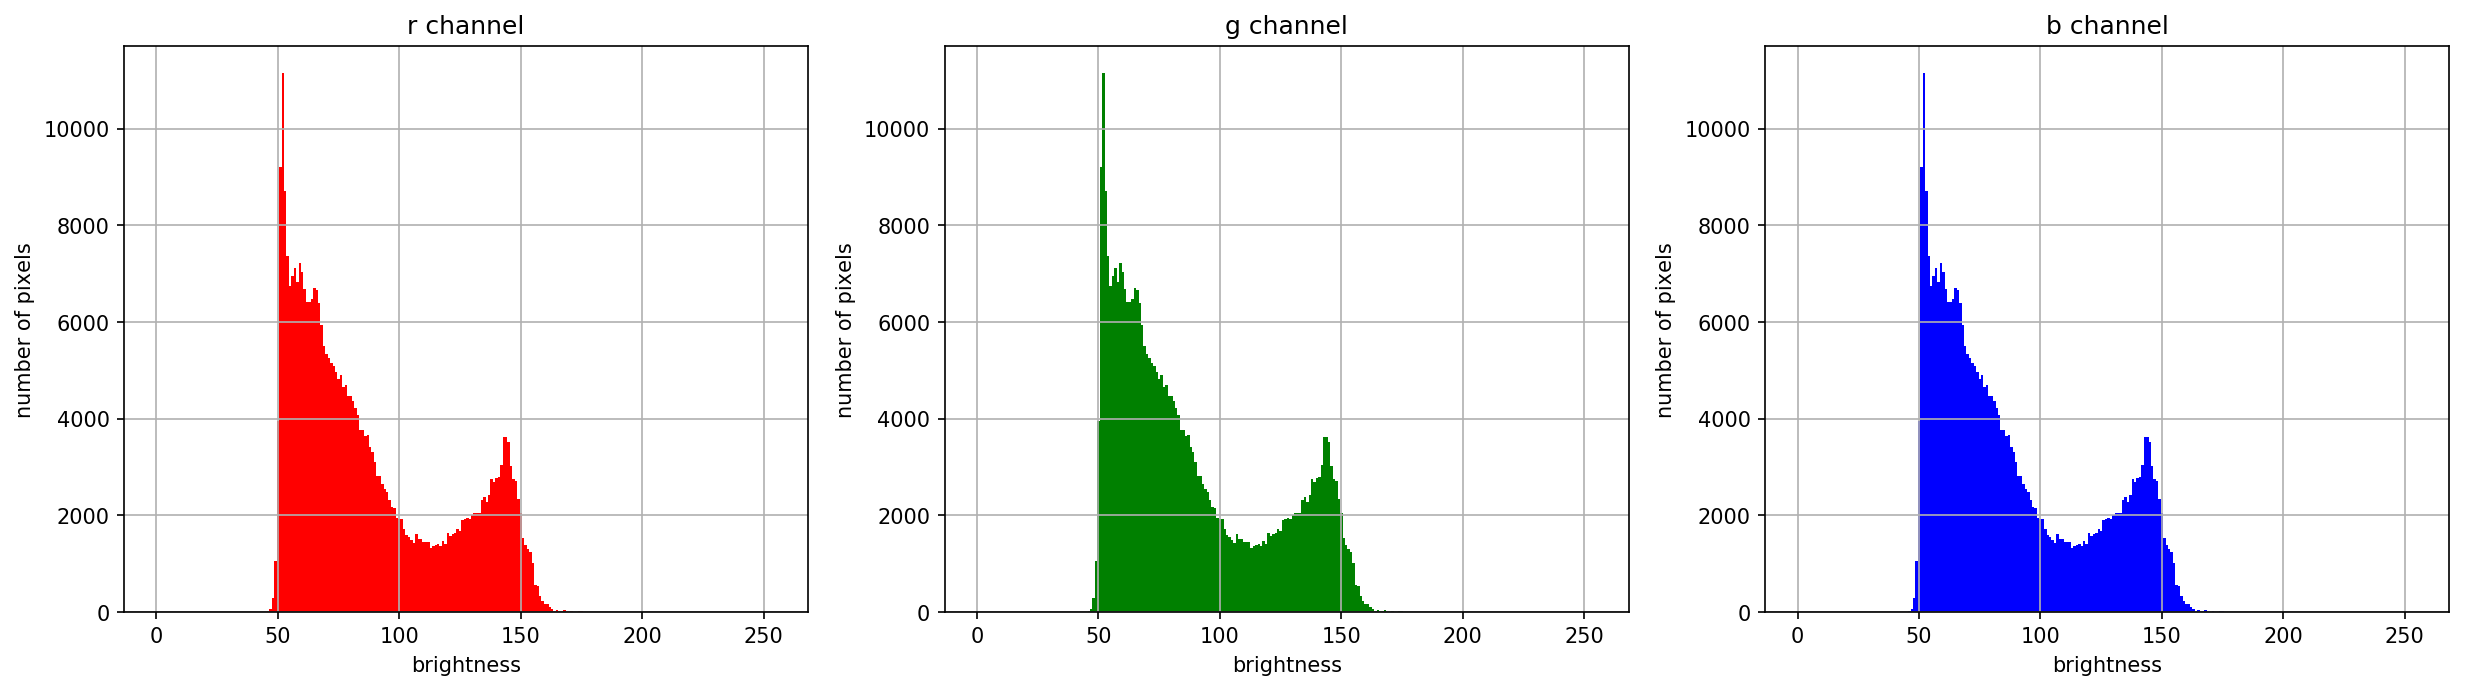

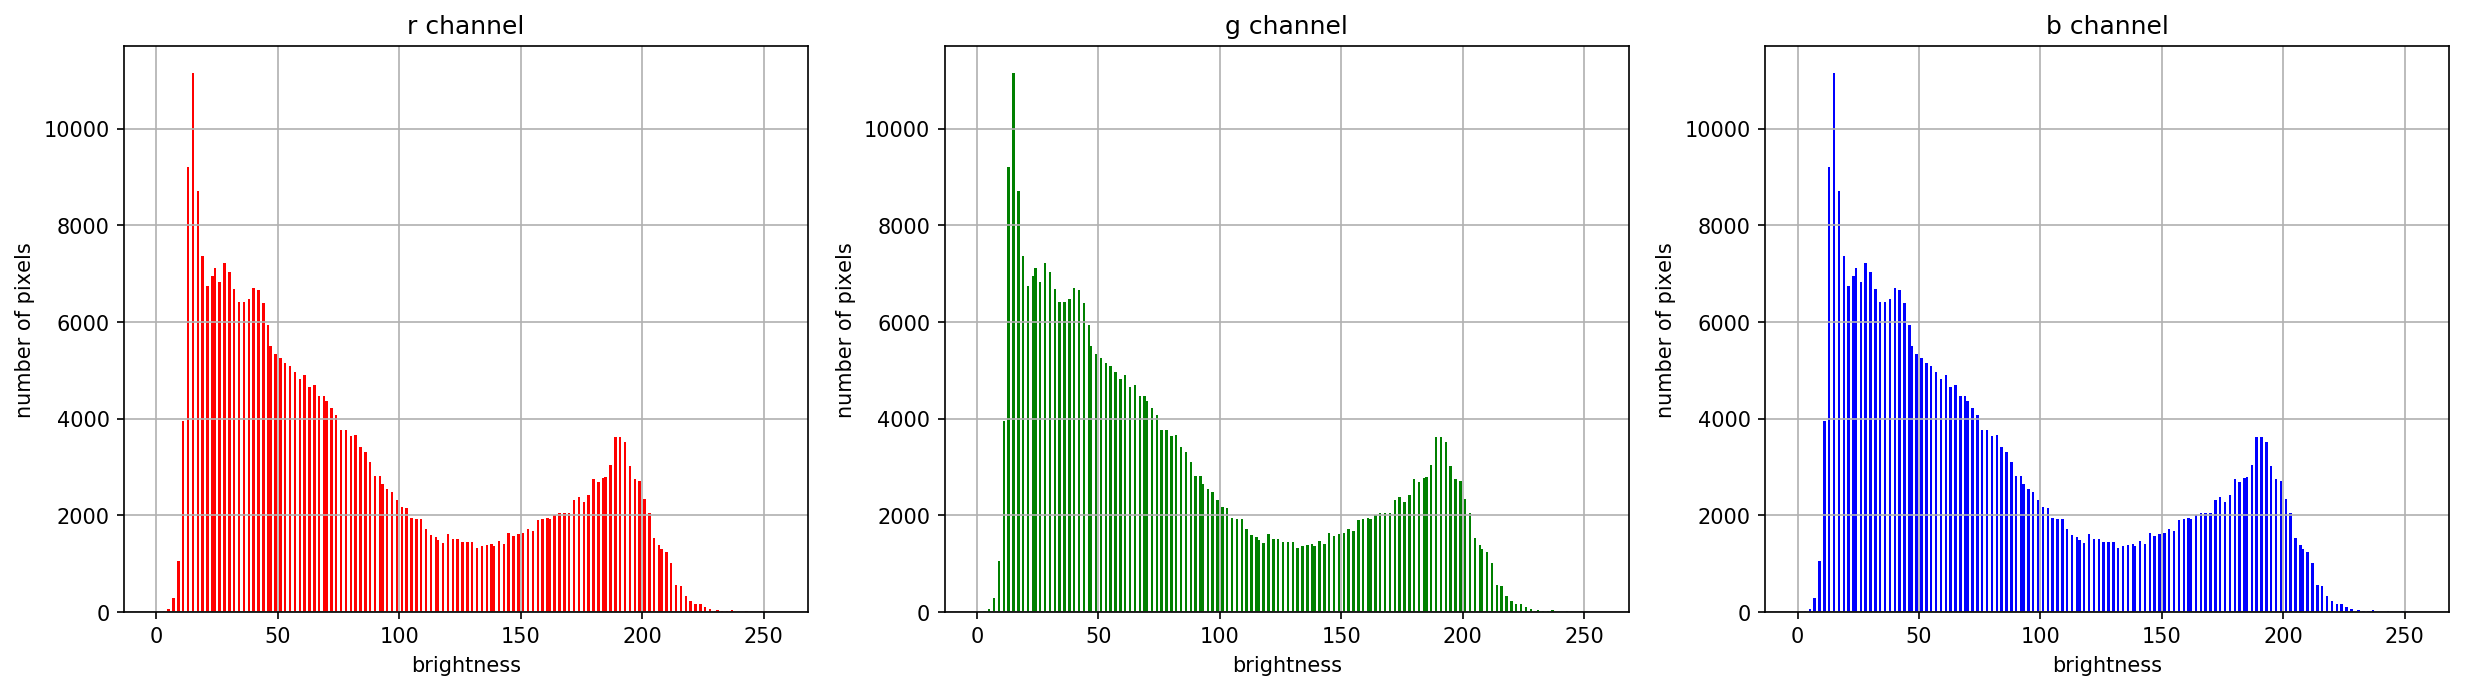

In [36]:
show_two_images((np_image_rgb, norm_img_rgb),title_arr=('Original image', 'Normalized'))
plot_hist_rgb(np_image_rgb, yscale_type='linear', title='Original')
plot_hist_rgb(norm_img_rgb, yscale_type='linear', title='Normalized')

# Эквализация

In [37]:
def equalization(np_img):
    temp_img = np.empty(np_img.shape)

    histogram, bin_edges = np.histogram(
            np_img.flatten(), bins=256, range=(0, 256)
    )
    
    histogram = histogram / histogram.sum()
    
    for i in range(1,256):
        histogram[i] = histogram[i-1] + histogram[i]
    for i in range(np_img.shape[0]):
        for j in range(np_img.shape[1]):
            temp_img[i,j] = 255.0 * histogram[np_img[i,j]]
    return temp_img


def equalization_rgb(np_img):
    temp_img = np.empty(np_img.shape)
    for i in range(3):
        temp_img[:,:,i] = equalization(np_img[:,:,i])
    return temp_img.astype('int')

In [38]:
eql_image = equalization(np_image)

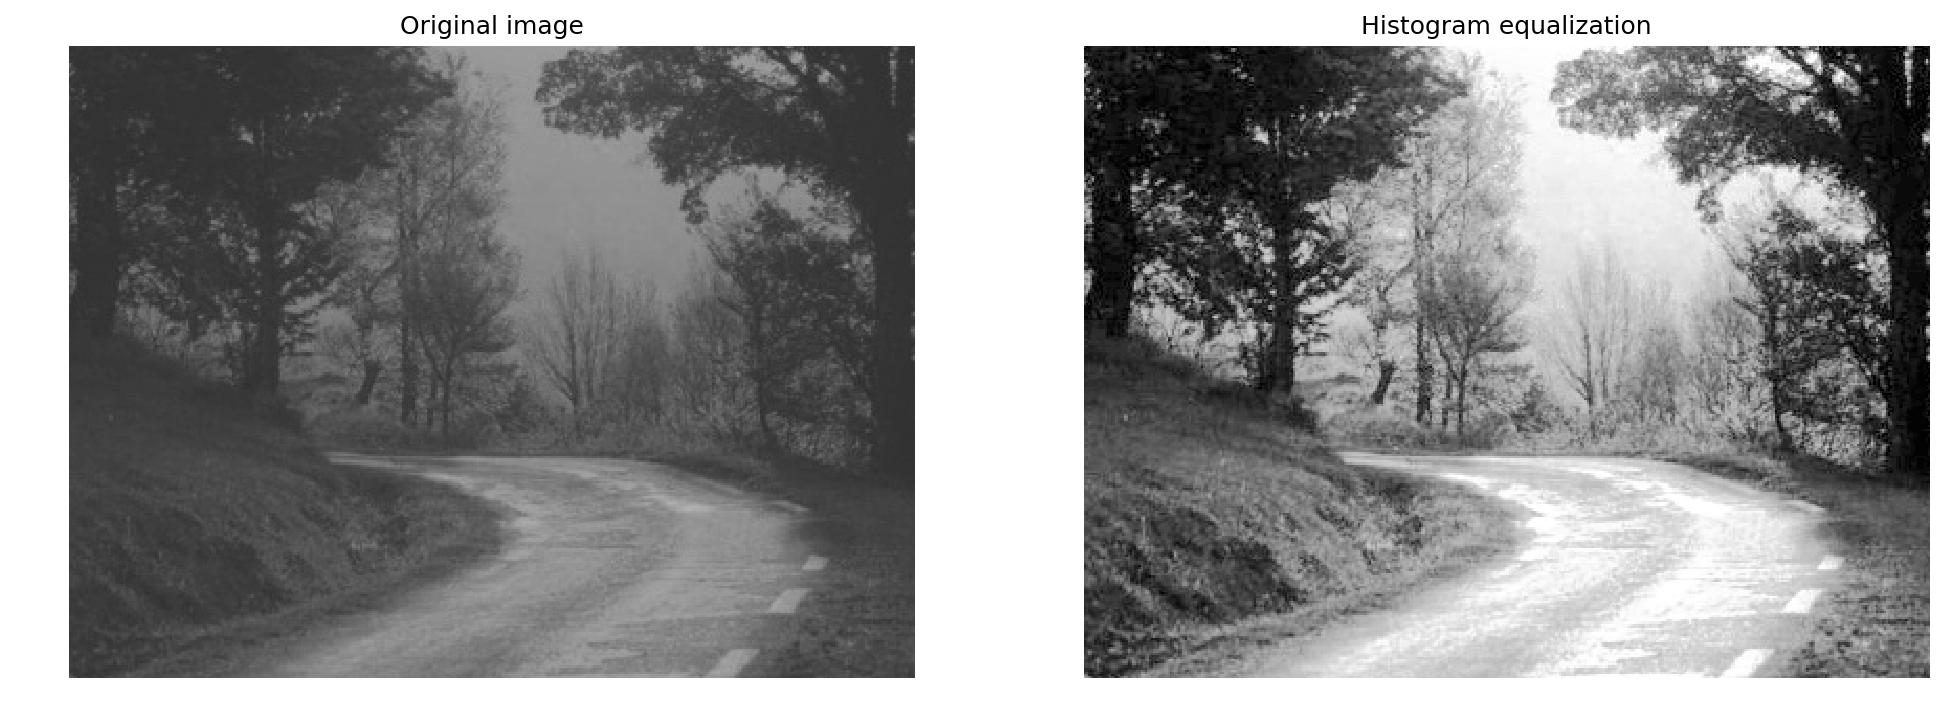

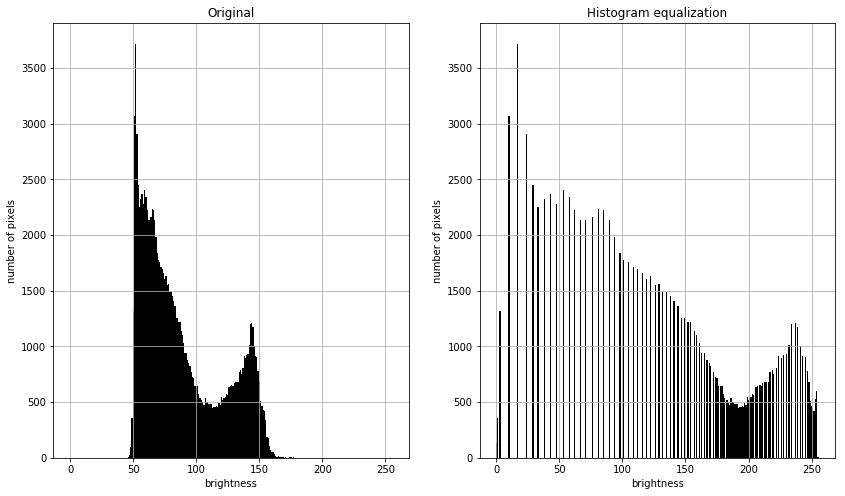

In [39]:
show_two_images((np_image, eql_image),title_arr=('Original image', 'Histogram equalization'), mode='grayscale')
plot_two_hist_compare((np_image, eql_image), title_arr=('Original', 'Histogram equalization'))

In [40]:
eql_image_rgb = equalization_rgb(np_image_rgb)

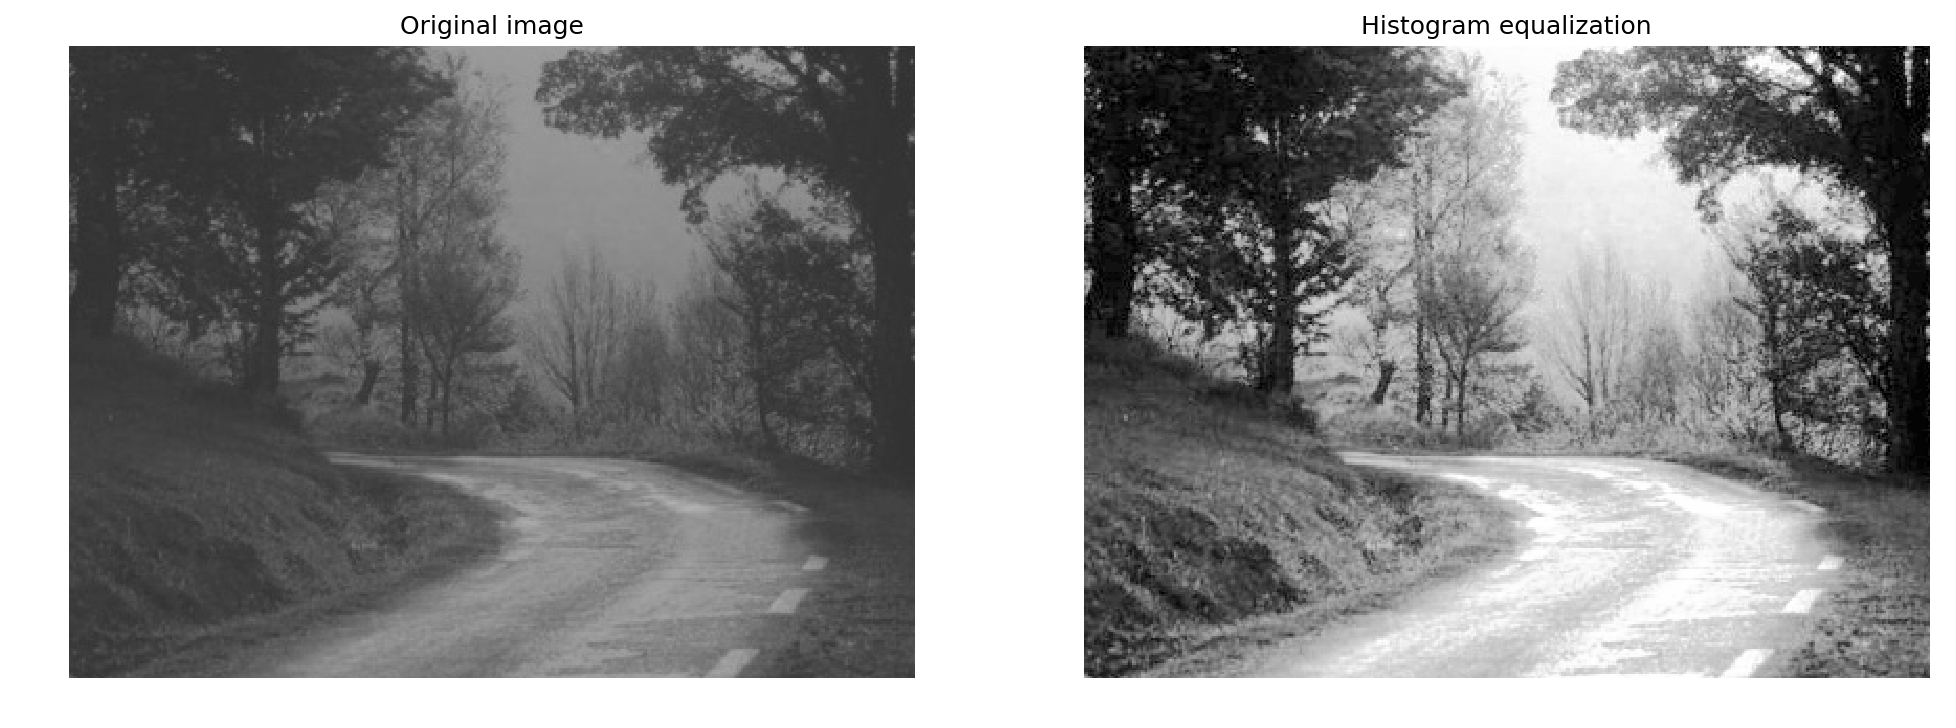

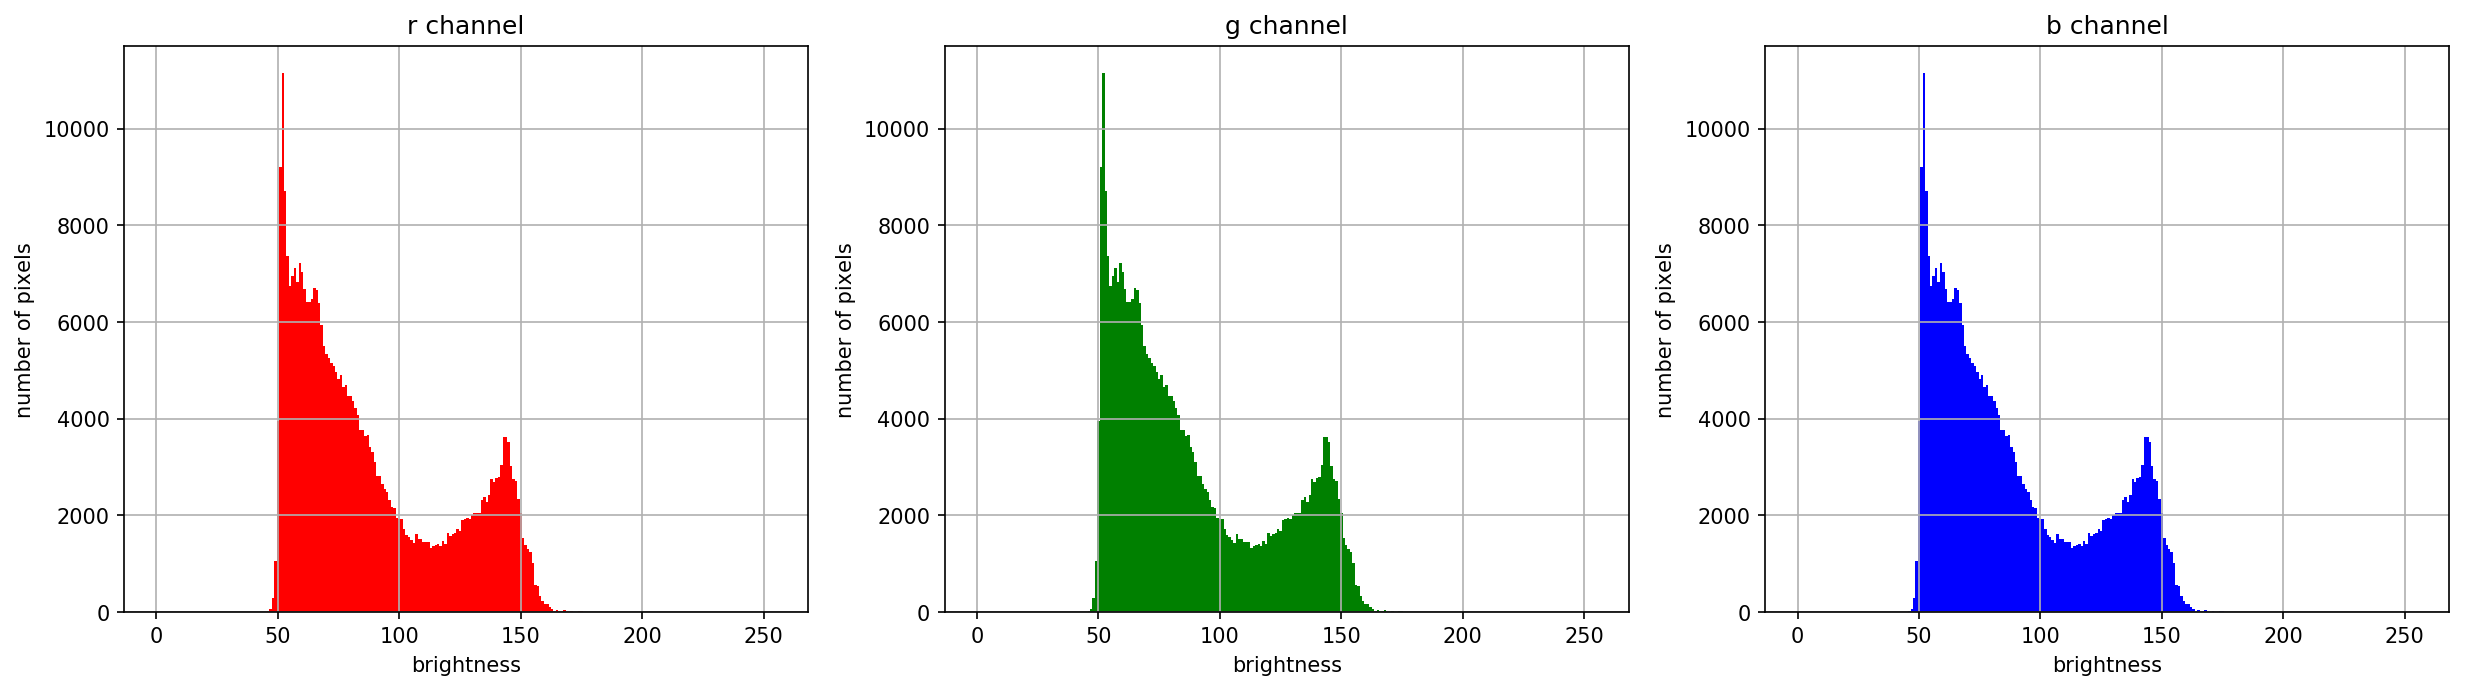

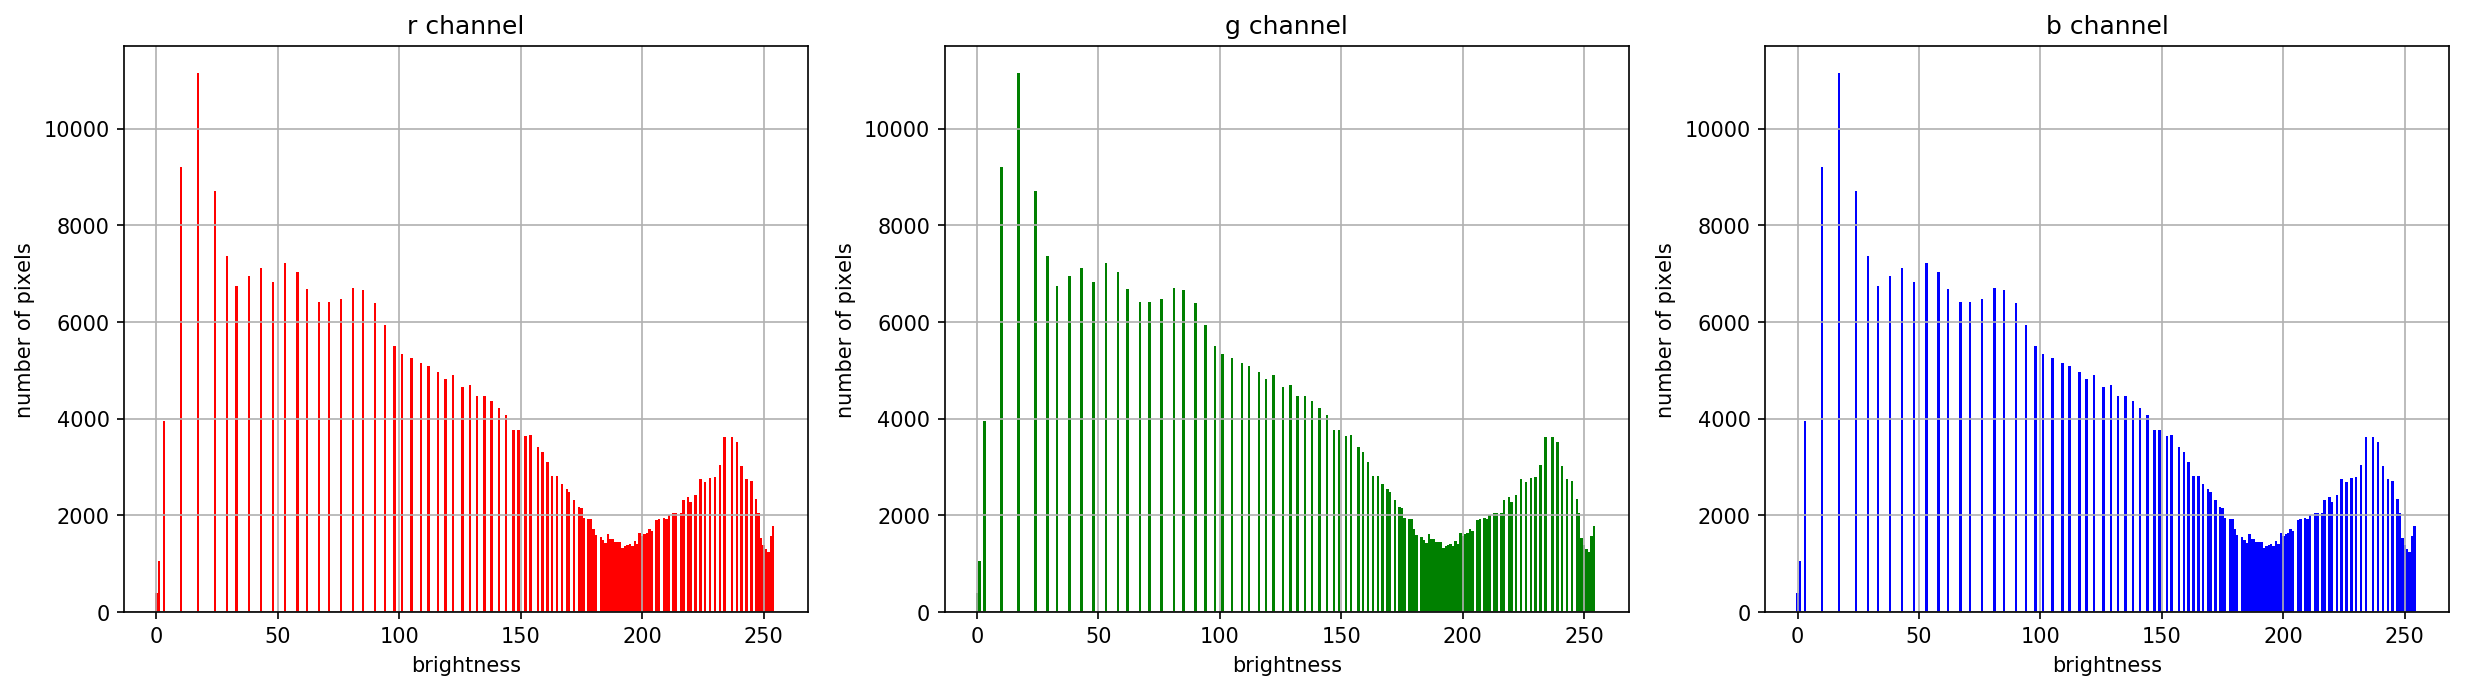

In [41]:
show_two_images((np_image_rgb, eql_image_rgb),title_arr=('Original image', 'Histogram equalization'))
plot_hist_rgb(np_image_rgb, yscale_type='linear', title='Original')
plot_hist_rgb(eql_image_rgb, yscale_type='linear', title='Histogram equalization')